# Estimación de Probabilidad de Radmisión de Pacientes Diabeticos.

In [1]:
from bs4 import BeautifulSoup
import requests

In [2]:
url = 'https://downloads.apache.org/spark/' 
r = requests.get(url)
html_doc = r.text
soup = BeautifulSoup(html_doc)

In [3]:
# leer la pagina web y obtener las versiones de spark disponibles
link_files = []
for link in soup.find_all('a'):
  link_files.append(link.get('href'))
spark_link = [x for x in link_files if 'spark' in x]  
print(spark_link)

['spark-2.4.8/', 'spark-3.0.3/', 'spark-3.1.2/', 'spark-3.2.0/']


In [4]:
ver_spark = spark_link[1][:-1] # obtener la version y eliminar el caracter '/' del final
print(ver_spark)

spark-3.0.3


In [5]:
import os # libreria de manejo del sistema operativo
#instalar automaticamente la version deseadda de spark
link = "https://www-us.apache.org/dist/spark/"
os.system(f"wget -q {link}{ver_spark}/{ver_spark}-bin-hadoop2.7.tgz")
os.system(f"tar xf {ver_spark}-bin-hadoop2.7.tgz")

# instalar pyspark
!pip install -q pyspark

     |████████████████████████████████| 281.3 MB 29 kB/s 
     |████████████████████████████████| 198 kB 42.4 MB/s 


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Instanciar Spark Session

In [7]:

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [8]:
%%html
<style>
  .output_stdout > pre{
      width:100000px !important;
  }
</style>

# Importar Librerias


In [9]:
# PySpark
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import *


from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
#Estandarización gaussiana de columnas
from sklearn.preprocessing import StandardScaler
#Librerías Machine Learning
#Segmentación de base entre Train y Test
from sklearn.model_selection import train_test_split
#Iteración de parametros
from sklearn.model_selection import GridSearchCV
#Estandarización gaussiana de columnas
from sklearn.preprocessing import StandardScaler
#Modelo Logístico
import xgboost as xgb

#from pandas_profiling import ProfileReport

from sklearn.linear_model import LogisticRegression as LR
# Modelo de Árbol de Decisión
from sklearn import tree
#Modelo de Random Forest
from sklearn.ensemble import RandomForestClassifier
# importacion de métricas de desempeño
from sklearn.metrics import f1_score,recall_score,precision_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report, precision_recall_fscore_support   #Estimación de metricas en los modelos
from sklearn.metrics import roc_curve, roc_auc_score     #Estimación de curva ROC y AUC
from sklearn.model_selection import cross_val_score       # Libreria para validacion cruzada
# Acurracy
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import KMeans

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier


# Python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

## Lectura y Exploración BBDD

In [10]:
path = "/content/drive/MyDrive/Data Scientist/dataset_diabetes/diabetic_data.csv"
df = spark.read.csv(path, header =True)

In [11]:
df = df.dropDuplicates()
df.show(3)

+------------+-----------+---------+------+-------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|     race|gender|    age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_s

In [12]:
# Dimensiones
print('La base contiene '+str(df.count())+' filas y ',str(len(df.columns))+' columnas')
df.printSchema()

La base contiene 101766 filas y  50 columnas
root
 |-- encounter_id: string (nullable = true)
 |-- patient_nbr: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- admission_type_id: string (nullable = true)
 |-- discharge_disposition_id: string (nullable = true)
 |-- admission_source_id: string (nullable = true)
 |-- time_in_hospital: string (nullable = true)
 |-- payer_code: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: string (nullable = true)
 |-- num_procedures: string (nullable = true)
 |-- num_medications: string (nullable = true)
 |-- number_outpatient: string (nullable = true)
 |-- number_emergency: string (nullable = true)
 |-- number_inpatient: string (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnos

In [13]:
# Casteo de Variables
df = df.withColumn("time_in_hospital", df.time_in_hospital.cast('float'))
df = df.withColumn("num_lab_procedures", df.num_lab_procedures.cast('float'))
df = df.withColumn("num_procedures", df.num_procedures.cast('float'))
df = df.withColumn("num_medications", df.num_medications.cast('float'))
df = df.withColumn("number_outpatient", df.number_outpatient.cast('float'))
df = df.withColumn("number_emergency", df.number_emergency.cast('float'))
df = df.withColumn("number_inpatient", df.number_inpatient.cast('float'))
df = df.withColumn("number_diagnoses", df.number_diagnoses.cast('float'))


In [14]:
df.printSchema()

root
 |-- encounter_id: string (nullable = true)
 |-- patient_nbr: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- admission_type_id: string (nullable = true)
 |-- discharge_disposition_id: string (nullable = true)
 |-- admission_source_id: string (nullable = true)
 |-- time_in_hospital: float (nullable = true)
 |-- payer_code: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: float (nullable = true)
 |-- num_procedures: float (nullable = true)
 |-- num_medications: float (nullable = true)
 |-- number_outpatient: float (nullable = true)
 |-- number_emergency: float (nullable = true)
 |-- number_inpatient: float (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: float (nullable = true)
 |-- max_glu_serum: stri

In [15]:
 categorical_cols = [item[0] for item in df.dtypes if item[1]=='string']
 numerical_cols = [item[0] for item in df.dtypes if item[1]!='string']


# Análisis Exploratorio de Datos



## Categorías por variable

In [16]:

for i in df.select(*categorical_cols):
    df2 = df.groupBy(i).count().show()

+------------+-----+
|encounter_id|count|
+------------+-----+
|    40451856|    1|
|    55003164|    1|
|    48634122|    1|
|    82741590|    1|
|    58222080|    1|
|    62619726|    1|
|   150759384|    1|
|    59850246|    1|
|   139043466|    1|
|   154479366|    1|
|    97915182|    1|
|     6815154|    1|
|   125386950|    1|
|   143247264|    1|
|    32340144|    1|
|    42932556|    1|
|    56476074|    1|
|   115604850|    1|
|   149218878|    1|
|   146721102|    1|
+------------+-----+
only showing top 20 rows

+-----------+-----+
|patient_nbr|count|
+-----------+-----+
|   18969354|    2|
|   23833737|    4|
|   23382171|    3|
|   23999787|    1|
|   25823484|    2|
|   42144660|    5|
|   35346321|    1|
|     776115|    3|
|   41658057|    8|
|   29145654|    2|
|   43799391|    1|
|   24157215|    1|
|  107818785|    1|
|   32807241|    1|
|   41776830|    1|
|      63702|    1|
|   62285715|    1|
|   24035283|    1|
|   14023503|    2|
|     520686|    1|
+---------

## Análisis de Missings

In [17]:
df.select([(100*count(when(col(c)=="?", c))/df.count()).alias(c) for c in df.columns]).show() 


+------------+-----------+------------------+------+---+-----------------+-----------------+------------------------+-------------------+----------------+----------------+-----------------+------------------+--------------+---------------+-----------------+----------------+----------------+--------------------+------------------+-----------------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|              race|gender|age|           weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|      payer_code|medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number

In [18]:
df.groupBy("gender").count().show()

+---------------+-----+
|         gender|count|
+---------------+-----+
|         Female|54708|
|Unknown/Invalid|    3|
|           Male|47055|
+---------------+-----+



**NOTA:**  
 - Se observa que la variable ```weight``` contiene un 96,8% de registros sin informar por lo que se considera no significativa y se elimina de la base.

- Se observa que las variables ```payer_code``` y ```medical_specialty``` tienen un 39% y 49% de registros sin informar, imputar esta información podria generar un sesgo del comportamiento real por lo que tambien se eliminan de la base.

- En otros casos no se observan variaciones significativas por lo que se procede a eliminar registros donde las variables  ```race```, ```diag_1```, ```diag_2```, ```diag_3```, presentan missings. 

- En particular la variable  ```gender``` tiene bajo nivel de información en la categoria "Unknown/Invalid" por que se eliminan registros con esta categoria.
 
 - Las variables ```citoglipton``` y  ```examide```, registran un valor único lo que no aporta información por lo que se eliminan.



In [19]:
columns_to_drop = ['weight', 'citoglipton', 'examide']
#'payer_code','medical_specialty',
df_1 = df.filter(col('diag_1')!="?").filter(col('diag_2')!="?").filter(col('diag_3')!="?").\
       filter(col('gender')!="Unknown/Invalid").filter(col("race")!="?").drop(*columns_to_drop)

In [20]:
# Vaerificación de sustitución de Missings
print('La base contiene '+str(df_1.count())+' filas y ',str(len(df_1.columns))+' columnas')

df_1.select([(100*count(when(col(c)=="?", c))/df_1.count()).alias(c) for c in df_1.columns]).show() 

La base contiene 98052 filas y  47 columnas
+------------+-----------+----+------+---+-----------------+------------------------+-------------------+----------------+-----------------+-----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|race|gender|age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|       payer_code|medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_s

## Clasificación de categorías
Se observa la presencia de una gran cantidad de categorias por variables, así que se procede a unificar en categorias más generales.


In [21]:

# Crear copya de base para analizar
base = df_1

 **readmitted   (TARGET)**
---
Se busca analizar si el paciente es readmitido en el hospital dentro de los 30 días o no. La variable ```readmitted``` contiene las categorías:
-   "<30"
-   "> 30" 
-   NO. 

Para reducir el análisis a una clasificación binaria, se combina la readmisión después de 30 días y la no readmisión en una sola categoría, es decir:
1: El paciente No es readmitido
2: El paciente es readmitido

 **medical_specialty**
---
Se reclasifican las categorias por especialidad.

 **Age** 
---
Se reclasifican las categorias por especialidad, bajo el supuesto de que las personas mayores pueden presentar mayor caso de diabetes


 **discharge_disposition_id**
---
Se realiza inicialmente una re-clasificación según conocimiento de negocio sin embargo dada la alta concentración de población en las categorias:

- 1: Discharged to home
- 3: Discharged/transferred to SNF
- 6: Discharged/transferred to home with home health service

se decide realizar un analisis de Información Value, buscando la mejor agrupación y se decide agrupar las restantes categorias en una única, llamada "others".


 **admission_source_id**
---
Se realiza inicialmente una re-clasificación según conocimiento de negocio sin embargo dada la alta concentración de población en las categorias:

- 7: Emergency Room
- 1:  Physician Referral
- Other

 **admission_type_id**
---
Las categorias 4, 5, 6, 8, se agrupan en una misma categoria

 **Variables Genericas***
---
Para las variables genericas indicadoras del comportamiento de la dosis en el paciente, se decide agrupar la información para cada categoria relacionada.


**Observación:**  

Para las variables ```payer_code```,```diag_1```,```diag_2```,```diag_3```, se observa una cantidad significativa de categorias sin una estructura clara de negocio que permita realizar una agrupación, por lo que deciden eliminarse de la base de trabajo.




In [22]:
# Readmitted  
no_readmit = ['NO', '>30']  #0

# medical_specialty
cardiology = ['Cardiology-Pediatric']
orthopedics = ['Orthopedics-Reconstructive','Osteopath']
pediatrics = ['Pediatrics-AllergyandImmunology','Pediatrics-CriticalCare','Pediatrics-EmergencyMedicine','Pediatrics-Endocrinology',
              'Pediatrics-Hematology-Oncology','Pediatrics-InfectiousDiseases','Pediatrics-Neurology', 'Pediatrics-Pulmonology']
neuro = ['Neurology','Neurophysiology','Psychiatry-Addictive','Psychiatry-Child/Adolescent','Psychology','Psychiatry']
surgery = ['Surgeon','Surgery-Cardiovascular','Surgery-Cardiovascular/Thoracic','Surgery-Colon&Rectal',
                                     'Surgery-General','Surgery-Maxillofacial','Surgery-Neuro','Surgery-Pediatric','Surgery-Plastic',
                                     'Surgery-PlasticwithinHeadandNeck','Surgery-Thoracic','Surgery-Vascular','SurgicalSpecialty']
gynecology = ['Obsterics&Gynecology-GynecologicOnco','Obstetrics','ObstetricsandGynecology']
radiology =['Radiology', 'Radiologist']
internal_medicine = ['InternalMedicine']
emergency_trauma =['Emergency/Trauma'],
family_general = ['Family/GeneralPractice']
no_informed = ['?']

# age
group_0_29 = ['[0-10)','[10-20)','[20-30)']
group_30_59 = ['[30-40)','[40-50)','[50-60)']
group_may_80 = ['[80-90)','[90-100)']

# discharge_disposition_id
#discharge_disp = [1,3,6]

# Variables Genericas
generical_feature = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',  	
                     'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 
                     'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
                     'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'] 


In [23]:

base1 = base.select('*', 
         when(col('readmitted').isin(no_readmit),lit("0")).otherwise(lit("1")).alias('target'), 
        
       when(col("medical_specialty").isin("?"), lit("no_informed"))\
        .when(col("medical_specialty").isin("Family/GeneralPractice"), lit("family_general"))\
        .when(col("medical_specialty").isin('Emergency/Trauma'), lit("emergency_trauma"))\
        .when(col("medical_specialty").isin('InternalMedicine'), lit("internal_medicine"))\
        .when(col("medical_specialty").isin(radiology), lit("radiology"))\
        .when(col("medical_specialty").isin(gynecology), lit("gynecology"))\
        .when(col("medical_specialty").isin(surgery), lit("surgery"))\
        .when(col("medical_specialty").isin(neuro), lit("neuro"))\
        .when(col("medical_specialty").isin(pediatrics), lit("pediatrics"))\
        .when(col("medical_specialty").isin(orthopedics), lit("orthopedics"))\
        .when(col("medical_specialty").isin(cardiology), lit("cardiology"))\
        .otherwise(lit("other")).alias("medical_specialty_rs"),

        when(col("payer_code")=="?", "no_informed").otherwise(col("payer_code")).alias("payer_code"),

        when(col("age").isin(group_0_29), lit("[0, 30)"))\
        .when(col("age").isin(group_30_59), lit("[30, 60)"))\
        .when(col("age") == "[60-70)", lit("[60-70)"))\
        .when(col("age") == "[70-80)", lit("[70-80)"))\
        .otherwise("[80-100)").alias("age_rs"),

        when(col("discharge_disposition_id") == "1", lit("discharged_to_home"))\
        .when(col("discharge_disposition_id") == "3", lit("discharged/transferred_to_SNF"))\
        .when(col("discharge_disposition_id") == "6", lit("discharged/transferred__home_with_home_health"))\
        .otherwise(lit("other")).alias("discharge_disposition_id_rs"),

        when(col("admission_source_id") == "1", lit("physician_referral"))\
        .when(col("admission_source_id") == "7", lit("emergency_room"))\
        .otherwise(lit("other")).alias("admission_source_id_rs"),

        when(col("admission_type_id")=="1", lit("emergency"))\
        .when(col("admission_type_id")=="2", lit("urgent"))\
        .when(col("admission_type_id")=="3", lit("elective"))\
        .when(col("admission_type_id")=="7", lit("trauma_center"))\
        .otherwise(lit("other")).alias("admission_type_id_rs"),



        
        


              ).drop("medical_specialty", "age", "readmitted", "discharge_disposition_id", "admission_source_id",
                     "payer_code", "diag_1", "diag_2", "diag_3","encounter_id",	"patient_nbr", 'admission_type_id_rs')


In [24]:
base1.show()

+---------------+------+-----------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+------+--------------------+--------+---------------------------+----------------------+
|           race|gender|admission_type_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|glimepiride|acetohexamide|glipizide|glyburide|tolbutamide|pioglitazone|rosiglitazone|acarbose|miglitol|troglitazone|tolazamide|insulin|glyburid

In [25]:
base1.printSchema()

root
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- admission_type_id: string (nullable = true)
 |-- time_in_hospital: float (nullable = true)
 |-- num_lab_procedures: float (nullable = true)
 |-- num_procedures: float (nullable = true)
 |-- num_medications: float (nullable = true)
 |-- number_outpatient: float (nullable = true)
 |-- number_emergency: float (nullable = true)
 |-- number_inpatient: float (nullable = true)
 |-- number_diagnoses: float (nullable = true)
 |-- max_glu_serum: string (nullable = true)
 |-- A1Cresult: string (nullable = true)
 |-- metformin: string (nullable = true)
 |-- repaglinide: string (nullable = true)
 |-- nateglinide: string (nullable = true)
 |-- chlorpropamide: string (nullable = true)
 |-- glimepiride: string (nullable = true)
 |-- acetohexamide: string (nullable = true)
 |-- glipizide: string (nullable = true)
 |-- glyburide: string (nullable = true)
 |-- tolbutamide: string (nullable = true)
 |-- pioglitazone: strin

In [26]:
# Convertir a Pandas
base_pd = base1.toPandas()

In [27]:
def dosis_med(df):
    df['steady'] = np.sum(df == "Steady")
    df['no'] = np.sum(df == "No")
    df['up'] = np.sum(df =='Up')
    df['down'] = np.sum(df =='Down')
    return df

In [28]:
# Agregación de variables genericas

df_gen = base_pd[generical_feature]
df_gen = df_gen.apply(dosis_med, axis = 1)
df_gen.head()

,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,steady,no,up,down
0,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,1,20,0,0
1,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,1,20,0,0
2,No,No,No,No,No,No,No,Up,No,No,No,No,No,No,No,Steady,No,No,No,No,No,1,19,1,0
3,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,1,20,0,0
4,No,No,No,No,No,No,No,Steady,No,Steady,No,No,No,No,No,No,No,No,No,No,No,2,19,0,0


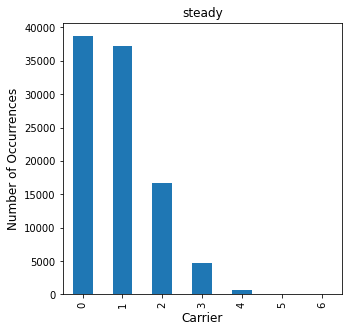

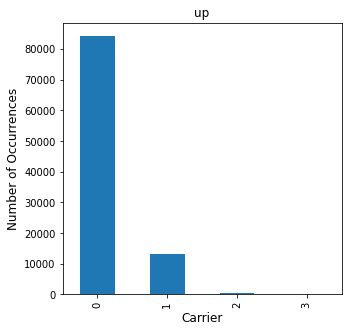

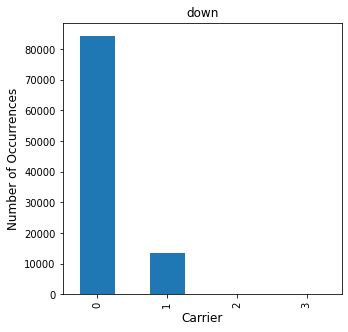

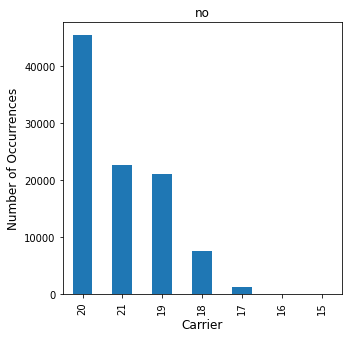

In [29]:
for i in df_gen[['steady', 'up', "down", 'no']].columns:
    #print(i, df[i].unique(), "\n")
    plt.figure(figsize=(5,5))
    ax = df_gen[i].value_counts().plot.bar()
    plt.title(str(i))
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('Carrier', fontsize=12)
    plt.show()

Por el comportamiento observado en las variables genericas, se decide consolidar la información en variables dicotomicas que resuman la información de los medicamentos

- ```steady```: La dosis se mantiene estable (1)
-  ```up```: Aumento la dosis
-  ```down```: disminuyo la dosis
-  ```no```: No se receto el medicamento

In [30]:
df_gen["steady"] = np.where(df_gen["steady"] == 0, "0", "1")
df_gen["up"] = np.where(df_gen["up"] == 0, "0", "1")
df_gen["down"] = np.where(df_gen["down"] == 0, "0", "1")
df_gen["no"] = np.where(df_gen["no"] == 0, "0", "1")


In [31]:
# Consolidar Información de trabajo
new_cols = df_gen[['steady', 'up', "down", 'no']]
base_pd2 = pd.concat([base_pd, new_cols], axis = 1)
base_pd2.drop(base_pd[generical_feature], axis = 1, inplace = True)
base_pd2.head()

,race,gender,admission_type_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,target,medical_specialty_rs,age_rs,discharge_disposition_id_rs,admission_source_id_rs,steady,up,down,no
0,Caucasian,Female,6,5.0,54.0,1.0,15.0,0.0,0.0,0.0,8.0,None,>8,No,Yes,0,orthopedics,[80-100),other,physician_referral,1,0,0,1
1,Caucasian,Male,6,9.0,65.0,5.0,28.0,0.0,0.0,0.0,7.0,None,None,No,Yes,0,internal_medicine,"[30, 60)",other,emergency_room,1,0,0,1
2,Caucasian,Male,1,8.0,65.0,3.0,23.0,0.0,0.0,0.0,8.0,None,None,Ch,Yes,1,other,[70-80),discharged/transferred_to_SNF,emergency_room,1,1,0,1
3,Caucasian,Female,6,5.0,70.0,0.0,9.0,0.0,0.0,0.0,5.0,None,None,No,Yes,0,other,[60-70),other,physician_referral,1,0,0,1
4,Caucasian,Female,1,1.0,38.0,0.0,6.0,0.0,0.0,0.0,3.0,None,None,Ch,Yes,1,family_general,"[30, 60)",discharged_to_home,emergency_room,1,0,0,1


# Análisis Grafico Bivariados

In [32]:


label = "target"
base_pd2_columns = list(base_pd2.columns)
base_pd2_columns.remove(label)
print(base_pd2_columns)


# Detectar variables númericas y categoricas.
# _get_numeric_data(): Selecciona variables númericas generando un nuevo DF
num_cols = list(base_pd2._get_numeric_data()) # Lista con nombres de var num
print(num_cols)

# A partir de las variables numericas se estima una nueva lista con variables categoricas
cat_cols = list(set(base_pd2) - set(num_cols))
cat_cols.remove(label)
print(cat_cols)


['race', 'gender', 'admission_type_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed', 'medical_specialty_rs', 'age_rs', 'discharge_disposition_id_rs', 'admission_source_id_rs', 'steady', 'up', 'down', 'no']
['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
['change', 'A1Cresult', 'steady', 'age_rs', 'up', 'diabetesMed', 'max_glu_serum', 'race', 'admission_source_id_rs', 'no', 'discharge_disposition_id_rs', 'medical_specialty_rs', 'admission_type_id', 'gender', 'down']


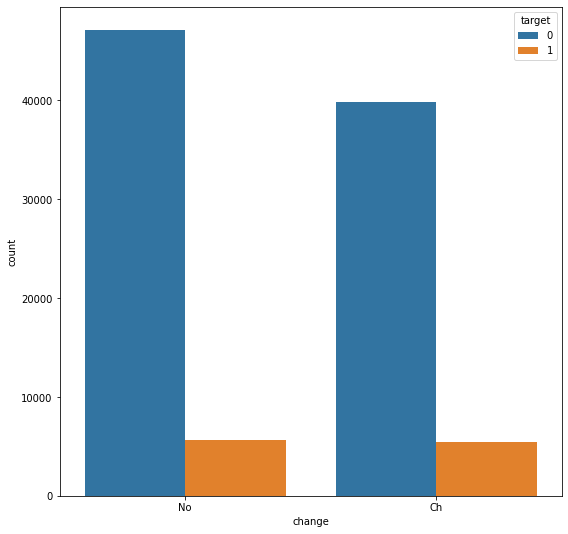

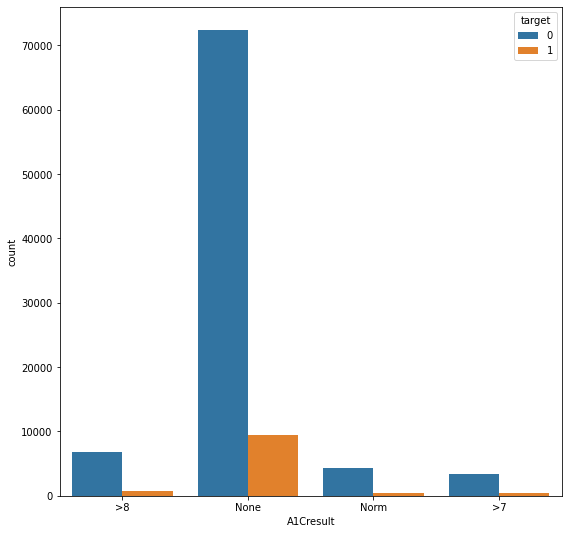

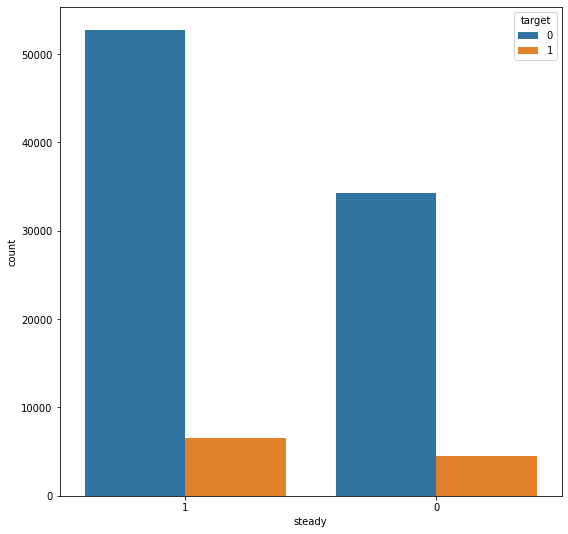

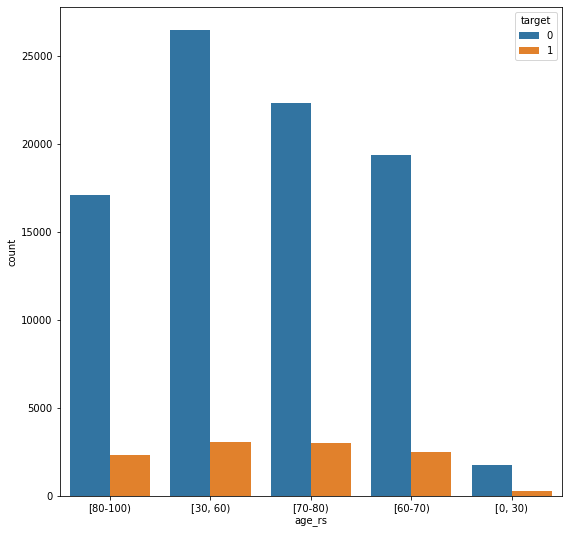

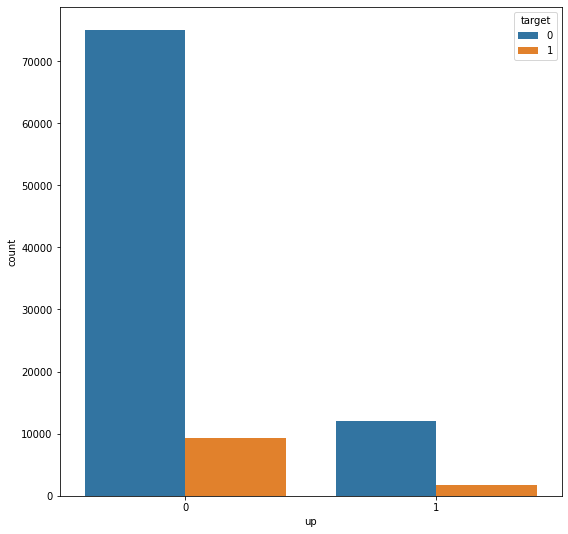

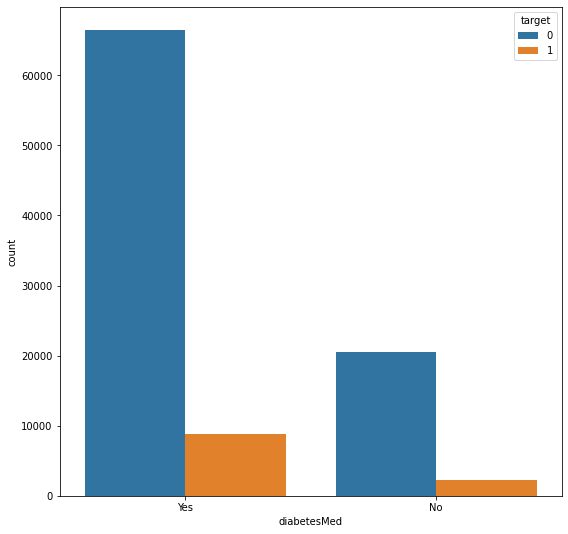

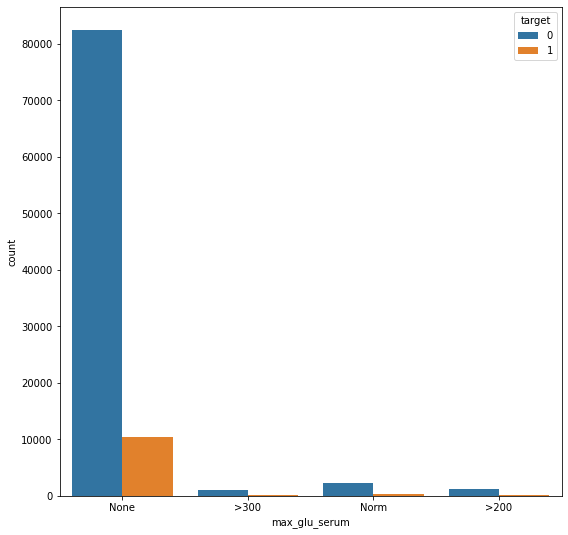

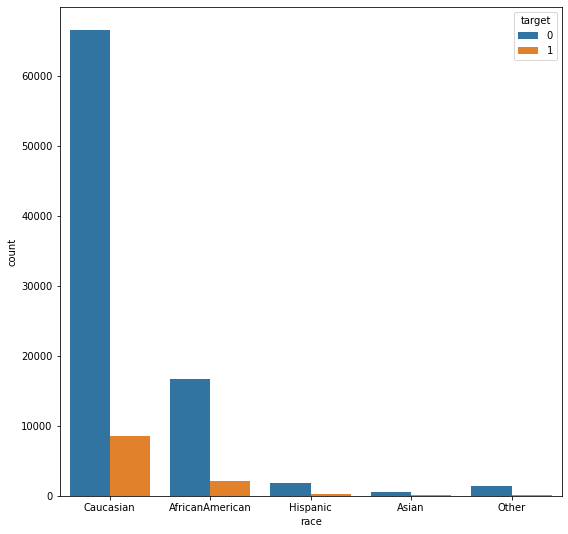

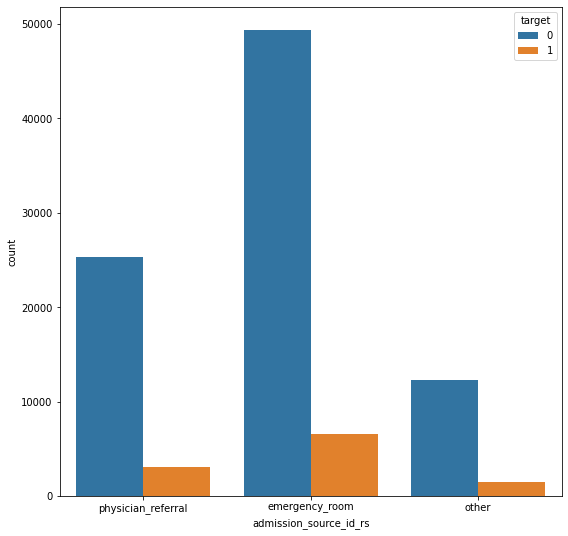

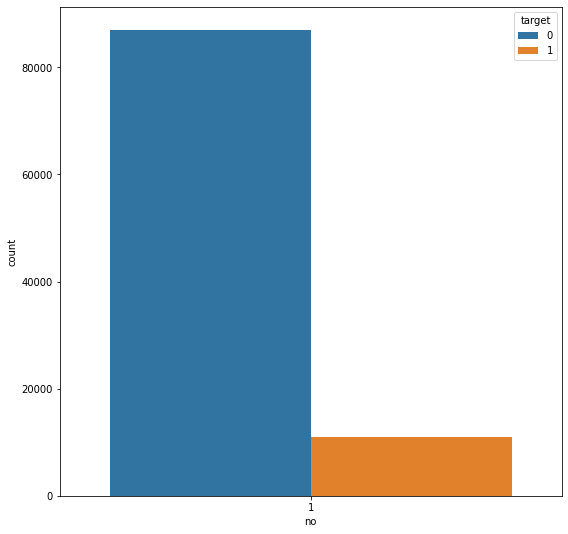

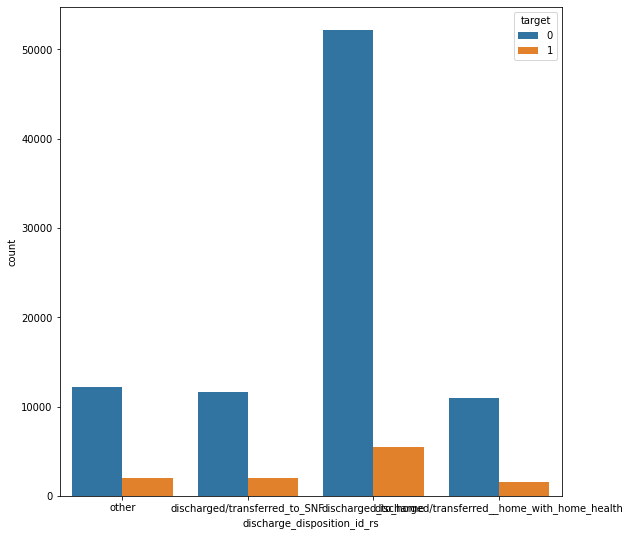

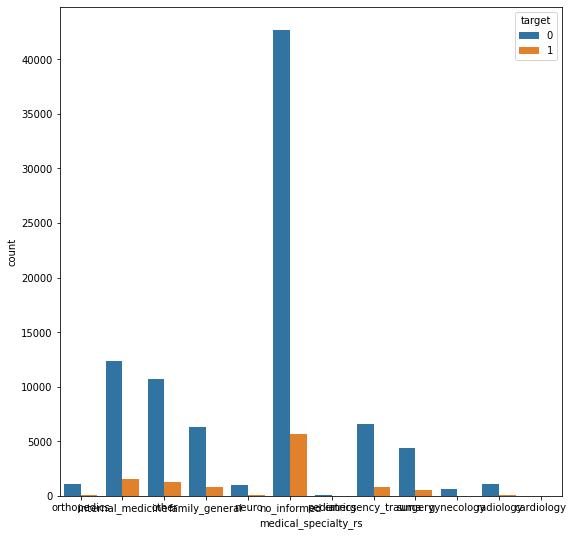

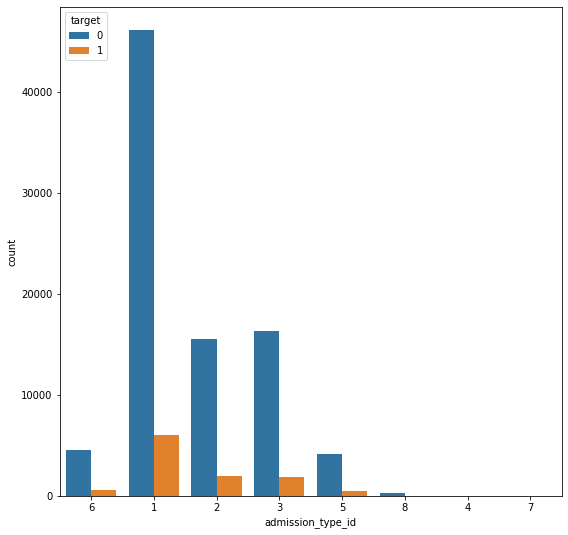

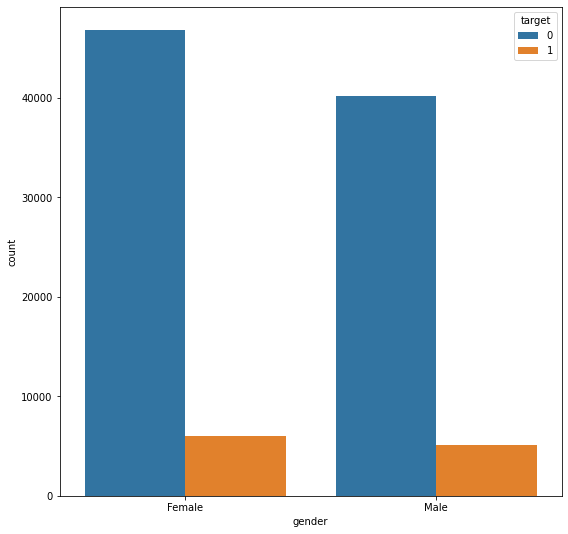

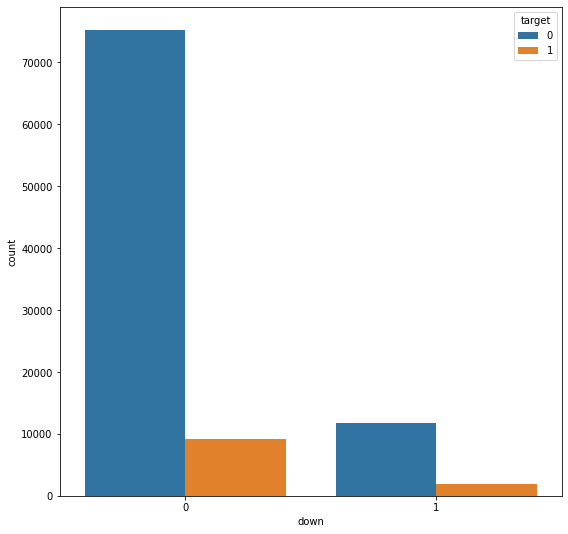

In [33]:
for col in cat_cols:
  plt.figure(figsize=(9,9))
  ax = sns.countplot(x = col, hue = label, data = base_pd2)

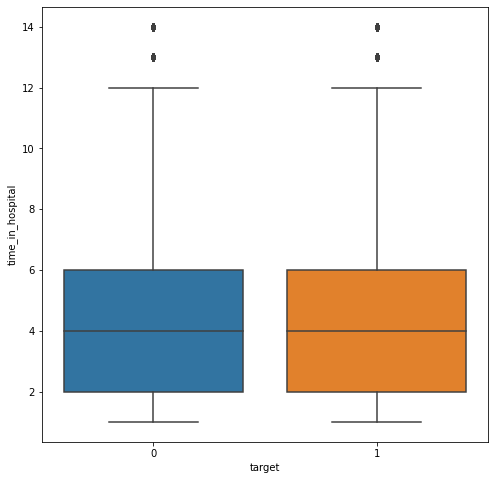

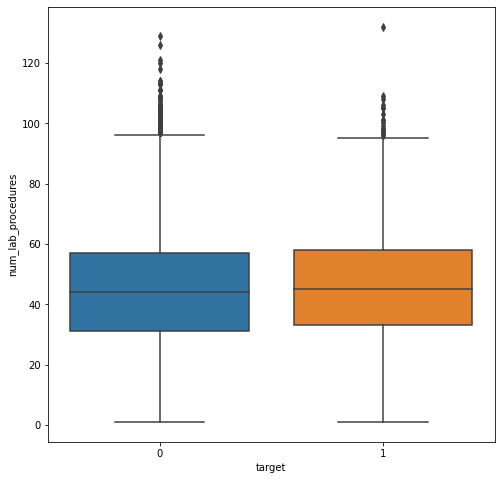

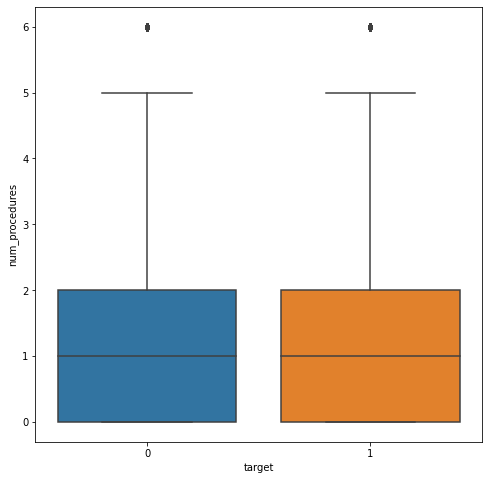

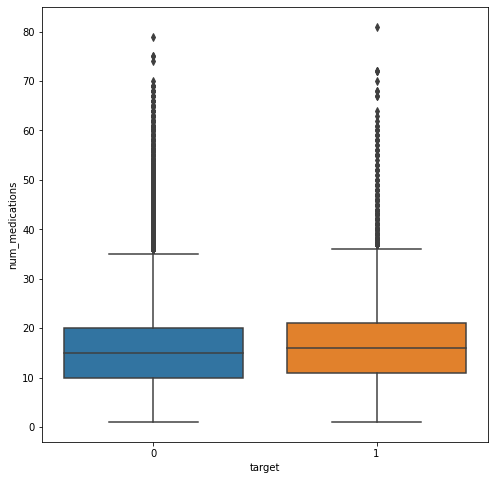

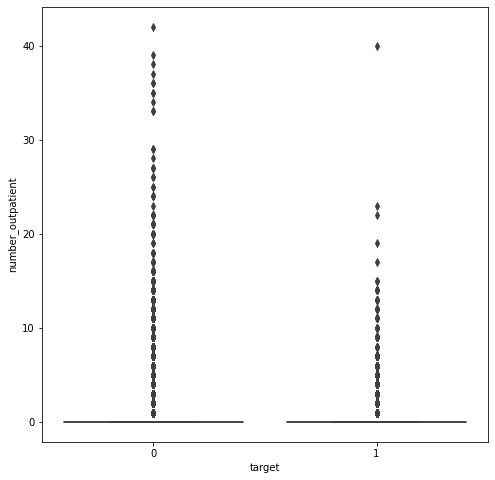

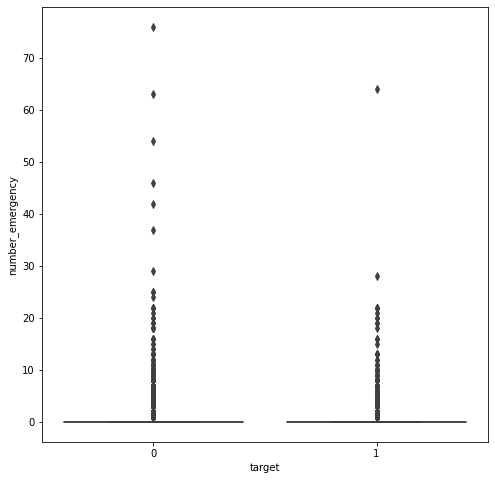

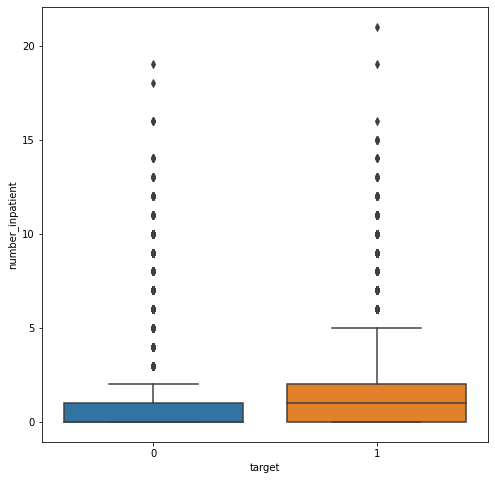

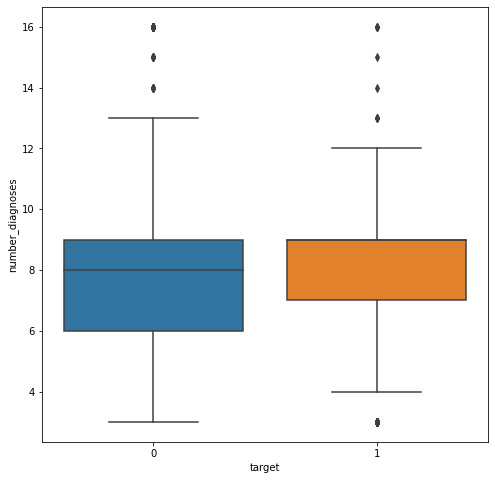

In [34]:

for col in num_cols:
  plt.figure(figsize=(8,8))
  ax = sns.boxplot(x = label, y = col, data = base_pd2)

# Codificación de datos categóricos

In [35]:
cat_cols

['change',
 'A1Cresult',
 'steady',
 'age_rs',
 'up',
 'diabetesMed',
 'max_glu_serum',
 'race',
 'admission_source_id_rs',
 'no',
 'discharge_disposition_id_rs',
 'medical_specialty_rs',
 'admission_type_id',
 'gender',
 'down']

In [36]:
base_pd_dummies=pd.get_dummies(base_pd2,columns=cat_cols)
print(base_pd_dummies.shape)
base_pd_dummies.head(3)


(98052, 67)


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,target,change_Ch,change_No,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,steady_0,steady_1,"age_rs_[0, 30)","age_rs_[30, 60)",age_rs_[60-70),age_rs_[70-80),age_rs_[80-100),up_0,up_1,diabetesMed_No,diabetesMed_Yes,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,admission_source_id_rs_emergency_room,admission_source_id_rs_other,admission_source_id_rs_physician_referral,no_1,discharge_disposition_id_rs_discharged/transferred__home_with_home_health,discharge_disposition_id_rs_discharged/transferred_to_SNF,discharge_disposition_id_rs_discharged_to_home,discharge_disposition_id_rs_other,medical_specialty_rs_cardiology,medical_specialty_rs_emergency_trauma,medical_specialty_rs_family_general,medical_specialty_rs_gynecology,medical_specialty_rs_internal_medicine,medical_specialty_rs_neuro,medical_specialty_rs_no_informed,medical_specialty_rs_orthopedics,medical_specialty_rs_other,medical_specialty_rs_pediatrics,medical_specialty_rs_radiology,medical_specialty_rs_surgery,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,gender_Female,gender_Male,down_0,down_1
0,5.0,54.0,1.0,15.0,0.0,0.0,0.0,8.0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
1,9.0,65.0,5.0,28.0,0.0,0.0,0.0,7.0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0
2,8.0,65.0,3.0,23.0,0.0,0.0,0.0,8.0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0


# Análisis de Correlación

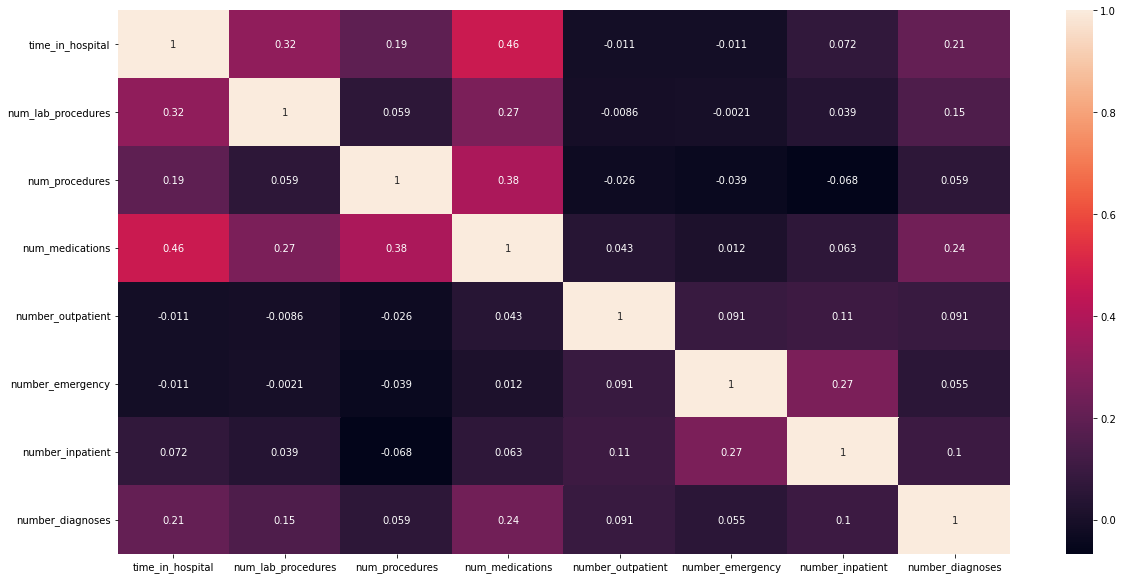

In [37]:
plt.figure(figsize=(20,10))
df_numerical_corr = base_pd_dummies[num_cols].corr()
sns.heatmap(df_numerical_corr, annot = True)
plt.show()

En general se observa una correlación alta de la variable "num_medications" con las variables "time_in_hospital" y "num_procedures" por lo que se decide eliminar de la data

In [38]:
base_pd_dummies.drop(base_pd_dummies[["num_medications"]], axis = 1, inplace = True)
base_pd_dummies.shape

(98052, 66)

# Modelamiento

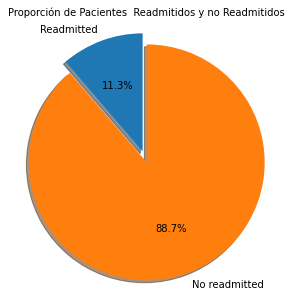

In [39]:
labels = 'Readmitted', 'No readmitted'
sizes = [base_pd_dummies.target[base_pd_dummies['target']=="1"].count(), 
         base_pd_dummies.target[base_pd_dummies['target']=="0"].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(5, 5))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proporción de Pacientes  Readmitidos y no Readmitidos", size = 10)
plt.show()

# 1: Readmitido
# 0. No Readmitido

## Manejo de datos desequilibrados

Dado que la cantidad de observaciones en la clase ```No readmitted``` es más alta que la cantidad de observaciones en la clase ```Readmitted``` el desequilibrio en la data puede sesgar los resultados y presentar un sobreajuste en el modelo, para resolver esto se utiliza  la técnica de remuestreo.

In [40]:
# Crear arrays (Separación de variables predictoras (x) y varibale objetivo (y))
y_origin = base_pd_dummies['target']
X_origin = base_pd_dummies.drop(['target'], axis=1)

Tamaño BD original Counter({'0': 86986, '1': 86986})
Tmaño BD remuestreo Counter({'0': 86986, '1': 86986})


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


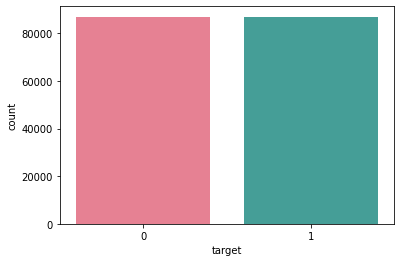

In [41]:
randomsample=  RandomOverSampler()
X,y=randomsample.fit_resample(X_origin,y_origin)

from collections import Counter
print('Tamaño BD original {}'.format(Counter(y)))
print('Tmaño BD remuestreo {}'.format(Counter(y)))
sns.countplot(y,palette='husl')

## Separación de Train y Test

In [42]:
feature_names = np.array(X.columns)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)  # 80% Train y 20% Test

## Selección de variables

In [44]:
# Selección de variables
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=25) 
ent = rfe.fit(X_train, y_train)

print('Número de caracteristicas: ', ent.n_features_)
print('Caracteristicas seleccionadas:', ent.support_)
print('Clasificación de caracteristicas:', ent.ranking_)


Número de caracteristicas:  25
Caracteristicas seleccionadas: [ True False False False  True  True  True False  True False False  True
 False  True  True False  True False False False False False  True  True
 False False  True False False False False False False False  True False
 False False  True  True  True False  True False  True False False False
  True False  True False  True False False False False  True False  True
 False False False  True  True]
Clasificación de caracteristicas: [ 1  4  6 20  1  1  1  2  1 18 16  1 17  1  1 36  1 13 12 27 29 37  1  1
 23 30  1 22  8 24 40 15  7  9  1 10 41 38  1  1  1 26  1 28  1 31 34 32
  1 19  1 33  1  3 11 25 39  1 35  1 14  5 21  1  1]


In [45]:
attributes = ent.support_
attributes = [feature_names[i] for i in list(attributes.nonzero()[0])]
attributes

['time_in_hospital',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'change_No',
 'A1Cresult_None',
 'steady_0',
 'steady_1',
 'age_rs_[30, 60)',
 'diabetesMed_No',
 'diabetesMed_Yes',
 'max_glu_serum_None',
 'admission_source_id_rs_other',
 'discharge_disposition_id_rs_discharged/transferred_to_SNF',
 'discharge_disposition_id_rs_discharged_to_home',
 'discharge_disposition_id_rs_other',
 'medical_specialty_rs_emergency_trauma',
 'medical_specialty_rs_gynecology',
 'medical_specialty_rs_orthopedics',
 'medical_specialty_rs_pediatrics',
 'medical_specialty_rs_surgery',
 'admission_type_id_5',
 'admission_type_id_7',
 'down_0',
 'down_1']

In [46]:
# Ajustar train y test a las variables seleccionadas
f = rfe.get_support(1) #the most important features
X_train2 = pd.DataFrame(X_train)[pd.DataFrame(X_train).columns[f]] # final features`
X_train2.head(3)


,0,4,5,6,8,11,13,14,16,22,23,26,34,38,39,40,42,44,48,50,52,57,59,63,64
0,2.460038,-0.229796,0.061453,0.778626,0.948052,-2.317535,-0.817897,0.817897,-0.637123,-0.526877,0.526877,0.244428,-0.397152,2.322784,-1.095790,-0.439172,-0.286643,-0.071302,-0.101355,-0.028682,-0.224168,-0.219676,-0.010723,0.425442,-0.425442
1,1.133955,-0.229796,0.675214,0.778626,-1.054795,-2.317535,1.222647,-1.222647,1.569557,-0.526877,0.526877,0.244428,-0.397152,-0.430518,0.912583,-0.439172,3.488656,-0.071302,-0.101355,-0.028682,-0.224168,-0.219676,-0.010723,-2.350499,2.350499
2,0.802434,-0.229796,0.675214,0.778626,0.948052,0.431493,1.222647,-1.222647,1.569557,1.897976,-1.897976,0.244428,-0.397152,-0.430518,-1.095790,-0.439172,3.488656,-0.071302,-0.101355,-0.028682,-0.224168,-0.219676,-0.010723,0.425442,-0.425442


In [47]:
X_test2 = pd.DataFrame(X_test)[pd.DataFrame(X_train2).columns] # final features`
X_test2.head(3)

,0,4,5,6,8,11,13,14,16,22,23,26,34,38,39,40,42,44,48,50,52,57,59,63,64
0,1.133955,-0.229796,-0.552308,0.778626,-1.054795,-2.317535,1.222647,-1.222647,1.569557,-0.526877,0.526877,0.244428,-0.397152,-0.430518,-1.095790,-0.439172,-0.286643,-0.071302,-0.101355,-0.028682,4.460947,-0.219676,-0.010723,-2.350499,2.350499
1,-0.523649,-0.229796,3.130257,0.216259,0.948052,0.431493,-0.817897,0.817897,-0.637123,-0.526877,0.526877,0.244428,-0.397152,-0.430518,-1.095790,-0.439172,-0.286643,-0.071302,-0.101355,-0.028682,-0.224168,-0.219676,-0.010723,0.425442,-0.425442
2,2.791559,-0.229796,-0.552308,0.778626,0.948052,0.431493,-0.817897,0.817897,-0.637123,-0.526877,0.526877,0.244428,-0.397152,-0.430518,0.912583,-0.439172,-0.286643,-0.071302,-0.101355,-0.028682,-0.224168,-0.219676,-0.010723,0.425442,-0.425442


## Modelo xgboost

In [48]:
xgb_model = xgb.XGBClassifier(scale_pos_weight = 1, min_child_weight = 1)
xgb_model.fit(X_train2, y_train)

y_train_pred = xgb_model.predict(X_train2)
y_test_pred = xgb_model.predict(X_test2)

print ('Accuracy sobre conjunto de Train:', metrics.accuracy_score(y_train, y_train_pred))
print ('Accuracy sobre conjunto de Test:', metrics.accuracy_score(y_test, y_test_pred))

Accuracy sobre conjunto de Train: 0.6128958089339475
Accuracy sobre conjunto de Test: 0.607069981319155


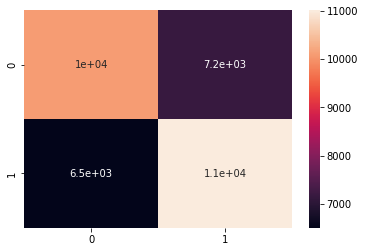

In [49]:
#Matriz de confusión 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)
#print(cm)
sns.heatmap(cm, annot=True)

## KNN

In [50]:
knn = KNeighborsClassifier(n_neighbors=10)
knn_train=knn.fit(X_train2, y_train)

In [51]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = knn_train.predict(X_train2)

# Predecimos sobre nuestro set de test
y_test_pred = knn_train.predict(X_test2)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', metrics.accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', metrics.accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.7302643396538221
Accuracy sobre conjunto de Test: 0.6883172869665182


## CART

In [52]:
CART = tree.DecisionTreeClassifier()
CART_train=CART.fit(X_train2, y_train)

# Predecimos sobre nuestro set de entrenamieto
y_train_pred = CART_train.predict(X_train2)

# Predecimos sobre nuestro set de test
y_test_pred = CART_train.predict(X_test2)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', metrics.accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', metrics.accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.8213138665153007
Accuracy sobre conjunto de Test: 0.774249173731858


## LDA

In [53]:
lda = LinearDiscriminantAnalysis()
lda_train=lda.fit(X_train, y_train)

In [54]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = lda_train.predict(X_train)

# Predecimos sobre nuestro set de test
y_test_pred = lda_train.predict(X_test)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', metrics.accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', metrics.accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.6002859667904898
Accuracy sobre conjunto de Test: 0.5977295588446616


## Regresión Logistica
---
Aplicación de Penalización "L2" sobre data set original



In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_origin, y_origin, test_size = 0.2, random_state = 0)  # 80% Train y 20% Test

In [57]:
# Selección de variables
model_lr = LogisticRegression()
rfe = RFE(model_lr, n_features_to_select=25) 
ent_lr = rfe.fit(X_train, y_train)

#print('Número de caracteristicas: ', ent_lr.n_features_)
#print('Caracteristicas seleccionadas:', ent_lr.support_)
#print('Clasificación de caracteristicas:', ent_lr.ranking_)

# Ajustar train y test a las variables seleccionadas
f = rfe.get_support(1) #the most important features
X_train_lr = pd.DataFrame(X_train)[pd.DataFrame(X_train).columns[f]] # final features`
X_test_lr = pd.DataFrame(X_test)[pd.DataFrame(X_train_lr).columns] # final features`

In [58]:

def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf
 
 #definimos funciona para mostrar los resultados
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


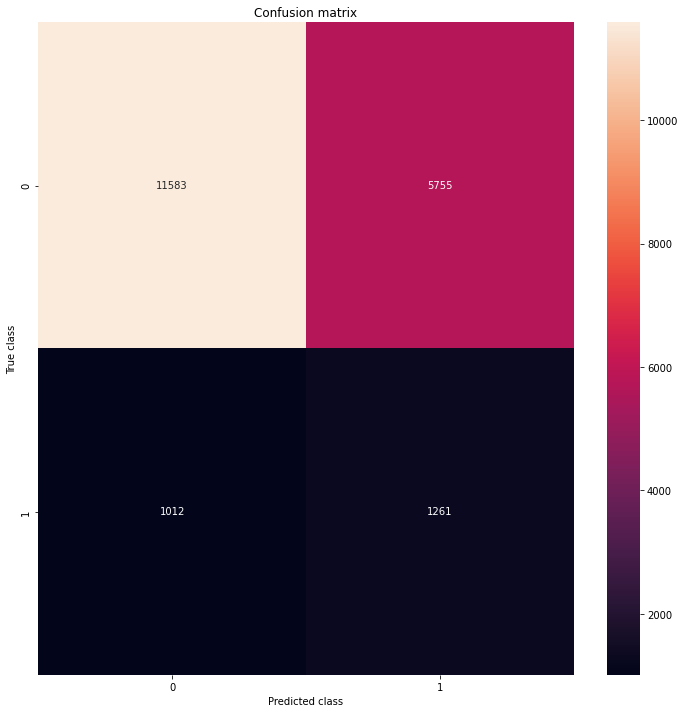

              precision    recall  f1-score   support

           0       0.92      0.67      0.77     17338
           1       0.18      0.55      0.27      2273

    accuracy                           0.65     19611
   macro avg       0.55      0.61      0.52     19611
weighted avg       0.83      0.65      0.72     19611



In [59]:
model = run_model_balanced(X_train_lr, X_test_lr, y_train, y_test)
pred_y = model.predict(X_test_lr)
mostrar_resultados(y_test, pred_y)

In [60]:
# Crear la predicción de  probabilidades para la variable obj  loan status usando test data
preds = model.predict_proba(X_test_lr)
preds_df1 = pd.DataFrame(preds[:,:], columns = ['prob_0', "prob_default(1)"])

y_test1 = pd.DataFrame(y_test)[["target"]].astype("float")

#reg_logistic.predict(X_test)  #Hace la predicción de la variable objetivo segun resultado modelo
#preds_df1.head()

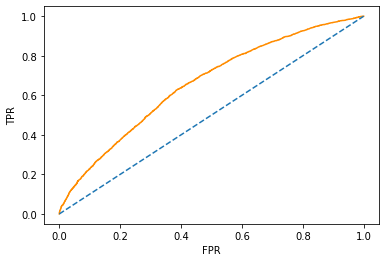

0.6582467238548977


In [61]:
# Create predictions and store them in a variable
preds = model.predict_proba(X_test_lr)

# Plot the ROC curve of the probabilities of default
prob_default = preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test1, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test1, prob_default)
print(auc)

In [63]:
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = model.predict(X_train_lr)

# Predecimos sobre nuestro set de test
y_test_pred = model.predict(X_test_lr)

# Comaparamos con las etiquetas reales
print('Accuracy sobre conjunto de Train:', metrics.accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', metrics.accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.6512538085949949
Accuracy sobre conjunto de Test: 0.6549385548926623
